In [87]:
#Bojana Ivanovic sw5/2015

import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections

# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

def select_roi(image_orig, image_bin):
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 5 and w > 15:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    #print("Prep",len(ready_for_ann))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

def select_roi_with_distances(image_orig, image_bin):
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if(h > 30):
            y = y - 30
            h = h + 30
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    
    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # izdvojiti sortirane parametre opisujucih pravougaonika
    # izracunati rastojanja izmedju svih susednih regiona po X osi i dodati ih u niz rastojanja
    for index in range(0, len(sorted_rectangles) - 1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index + 1]
        distance = next_rect[0] - (current[0] + current[2]) # x_next - (x_current + w_current)
        #distancey = next_rect[1] - (current[1] + current[3])
        region_distances.append(distance)
        #region_distances.append(distancey)        
    
    return image_orig, sorted_regions, region_distances

def display_result_with_spaces(outputs, alphabet, k_means):
    # odredjivanje indeksa grupe koja odgovara rastojanju izmedju reci
    w_space_group = max(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    # iterativno dodavanje prepoznatih elemenata
    # dodavanje space karaktera ako je rastojanje izmedju dva slova odgovara rastojanju izmedju reci
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_space_group:
            result += ' '
        result += alphabet[winner(output)]
    return result

from sklearn.cluster import KMeans


Training started...

Training completed...


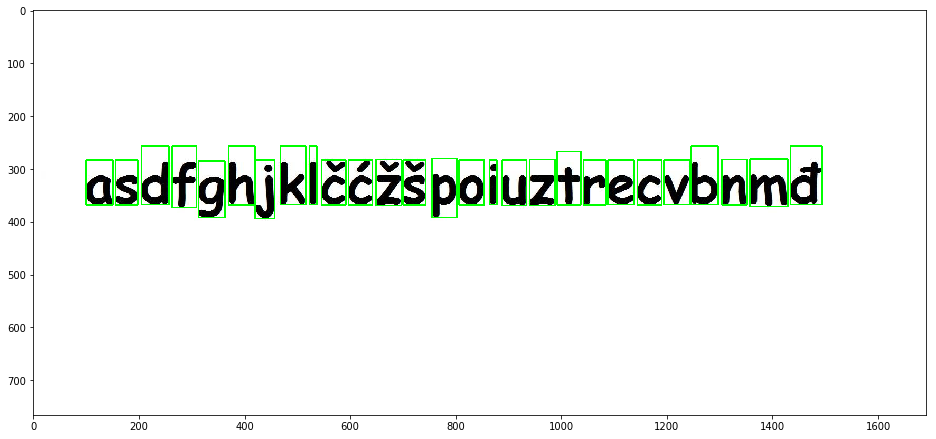

In [80]:
alphabet_letters=['a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'č', 'ć', 'ž', 'š', 'p', 'o', 'i',
                 'u', 'z', 't', 'r', 'e', 'c', 'v', 'b', 'n', 'm', 'đ']

image_test = load_image('images/obcavanje.jpg')
img_test = invert(image_bin(image_gray(image_test)))
img_test_bin = erode(dilate(img_test))
selected_reg_test, letters_test, tr = select_roi_with_distances(image_test.copy(), img_test)
display_image(selected_reg_test)

inputs = prepare_for_ann(letters_test)
outputs = convert_output(alphabet_letters)
ann = create_ann(len(alphabet_letters))
train_ann_var = train_ann(ann, inputs, outputs,2000)



28
28
čitanje povećava inteligenciju


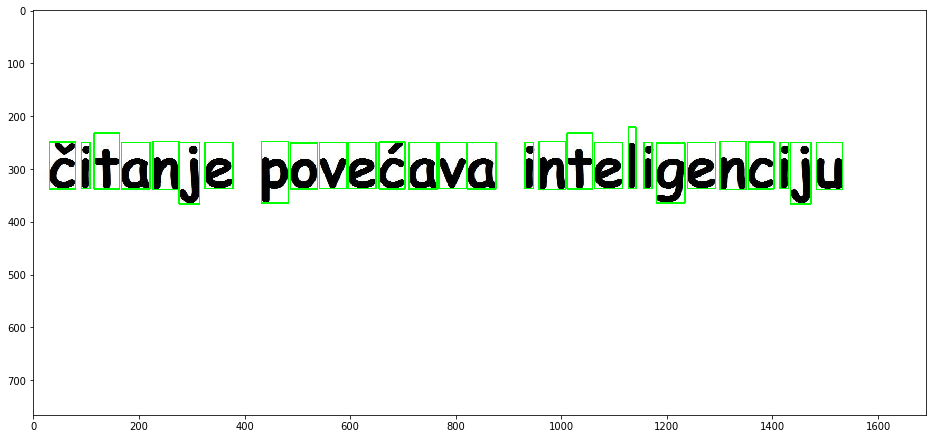

In [91]:
image_test = load_image('images/testiranje.jpg')
img_test = invert(image_bin(image_gray(image_test)))
img_test_bin = erode(dilate(img_test))
selected_reg_test, letters_test, tr = select_roi_with_distances(image_test.copy(), img_test)
display_image(selected_reg_test)

print("Broj regiona: ", len(letters_test))
display_image(selected_reg_test)

tr = np.array(tr).reshape(len(tr), 1)

k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means.fit(tr)

inp = prepare_for_ann(letters_test)
res = ann.predict(np.array(inp, np.float32))
print(display_result_with_spaces(res, alphabet_letters, k_means))